In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

In [2]:
class Animal:
    
    # requried variables: needed for subclasses
    location = [0,0]
    stepSize = 1
    mapSize = 0
    foodEaten = 0
    hunger = 0
    maxHunger = 0
    probRepro = 0
    sense = 1
    alive = True
    beStill = False
    
    def __init__(self, mapSize, stepSize=None, location=None, maxHunger = 1000):
        
        if location == None:
            location = [np.random.randint(0, mapSize), np.random.randint(0, mapSize)]
        self.location = location
                
        self.mapSize = mapSize
        self.foodEaten = 0
        self.hunger = 0
        self.alive = True
        self.maxHunger = maxHunger
        
    def step(self):
        self.hunger = self.hunger + 1
        #move once for every stepSize
        for i in range(0, self.stepSize):
            
            #one for each direction
            direct = np.random.randint(0,8)
            
            # if the direction is 1,0,7 move x by +1
            if ((direct==0) or (direct==1) or (direct==7)):
                self.location[0] = self.location[0] + 1
                
            # if the direction is 1,2,3 move y by +1
            if ((direct==1) or (direct==2) or (direct==3)):
                self.location[1] = self.location[1] + 1
                
            # if the direction is 3,4,5 move x by -1
            if ((direct==3) or (direct==4) or (direct==5)):
                self.location[0] = self.location[0] - 1
                
            # if the direction is 5,6,7 move y by -1
            if ((direct==5) or (direct==6) or (direct==7)):
                self.location[1] = self.location[1] - 1
            
    # check if location needs to wrap
    def locationCheck(self):
        
        for i in range(0,2):
            if (self.location[i] > self.mapSize):
                self.location[i] = self.location[i] - self.mapSize
            elif (self.location[i] < 0):
                self.location[i] = self.mapSize - self.location[i]

In [3]:
class Food:
    location = []
    eaten = False
    mapSize = 0
    
    def __init__(self, mapSize, location = None):
        
        if location == None:
            location = [np.random.randint(0, mapSize), np.random.randint(0, mapSize)]
        self.location = location
        
        self.mapSize = mapSize

In [4]:
class Rabbit(Animal):
    
    probRepro = 0.5
    litter = 1                                     # Edit this value?
    species = 'Rabbit'
    eatMush = False
    
    def reproduced(rabbit2):
        self.hunger = self.hunger * 1.25           # Edit this value?
        rabbit2.hunger = rabbit2.hunger * 1.25     # Edit this value?
        
    def interactRabbit(rabbit, animalArray):
        together = False
        if not rabbit.beStill:
            together = vicinityCheck(self, rabbit)
        if together:
            if ((np.rand.ranf(0, 1) < self.probRepro)):
                for i in range(0, self.litter):
                    reproduce(animalArray, self)
                self.reproduced(rabbit)    
        
    def interactMushroom(mushroom):
        together = vicinityCheck(self, mushroom)
        if together:
            mushroom.eaten = True
            self.hunger = self.hunger / 1.25       # Edit this value?

In [5]:
class Fox(Animal):
    
    probRepro = 0.3
    litter = 1                                         # Edit this value?
    species = 'Fox'
    
    def reproduced(fox):
        self.hunger = self.hunger * 1.25               # Edit this value?
        fox.hunger = fox.hunger * 1.25                 # Edit this value?
        
    def interactRabbit(rabbit):
        
        together = False
        if not rabbit.beStill:
            together = vicinityCheck(self, rabbit)
        if (together):
            rabbit.beStill = True
            self.hunger = self.hunger / 1.25 # Edit this value?
        
    def interactFox(fox, animalArray):
        together = False
        if not fox.beStill:
            together = vicinityCheck(self, fox)
        if together:
            if ((np.rand.ranf(0, 1) < self.probRepro)):
                for i in range(0, self.litter):
                    reproduce(animalArray, self)
                self.reproduced(fox)

In [6]:
class Mushroom(Food):
    
    species = 'Mushroom'

In [7]:
def hungerCheck(animalArray):
        
    everyoneDead = True
    for i in range(0, len(animalArray)):
        
        hunger = animalArray.hunger
        maxHunger = animalArray.maxHunger
        
        if hunger > maxHunger:
            animalArray(i).beStill = True
        else:
            everyoneDead = False
            
    return animalArray, everyoneDead

def vicinity(animal1, animal2):
    
    a1X = animal1.location[0]
    a1Y = animal1.location[1]
    a2X = animal2.location[0]
    a2Y = animal2.location[1]
    sense = animal1.sense
    nearby = False
    
    for i in range(-sense, (sense+1)):
        if (a1X == (a2X + i)):
            i = 2
            for j in range(-sense, (sense+1)):
                if (a1Y == (a2Y + j)):
                    nearby = True
                    j = 2
    return nearby

def reproduce(animalArray, animal):
    
    if(animalArray[0].species == 'Rabbit'):
        animalArray.append(Rabbit(animalArray[0].mapsize, animal.location))
        animalArray[len(animalArray)].step_size = 8
        animalArray[len(animalArray)].step()
        animalArray[len(animalArray)].step_size = animal.step_size
        
    elif(animalArray[0].species == "Fox"):
        animalArray.append(Fox(animalArray[0].mapsize, animal.location))
        animalArray[len(animalArray)].step_size = 8
        animalArray[len(animalArray)].step()
        animalArray[len(animalArray)].step_size = animal.step_size

In [8]:
def mapToGrid(grid, foxes_array, rabbits_array, mush_array):
    # map a mushroom if its still not eaten
    for i in range(len(mush_array)):
        if not mush_array[i].eaten:
            x = mush_array[i].location[0]
            y = mush_array[i].location[1]
            grid[x, y] = 1
    
    # map a rabbit to grid if its alive
    for i in range(len(rabbits_array)):
        if not rabbits_array[i].beStill:
            x = rabbits_array[i].location[0]
            y = rabbits_array[i].location[1]
            grid[x, y] = 2
    
    # map a fox to grid if its alive
    for i in range(len(foxes_array)):
        if not foxes_array[i].beStill:
            x = foxes_array[i].location[0]
            y = foxes_array[i].location[1]
            grid[x, y] = 3
    
    return grid

Initial condition


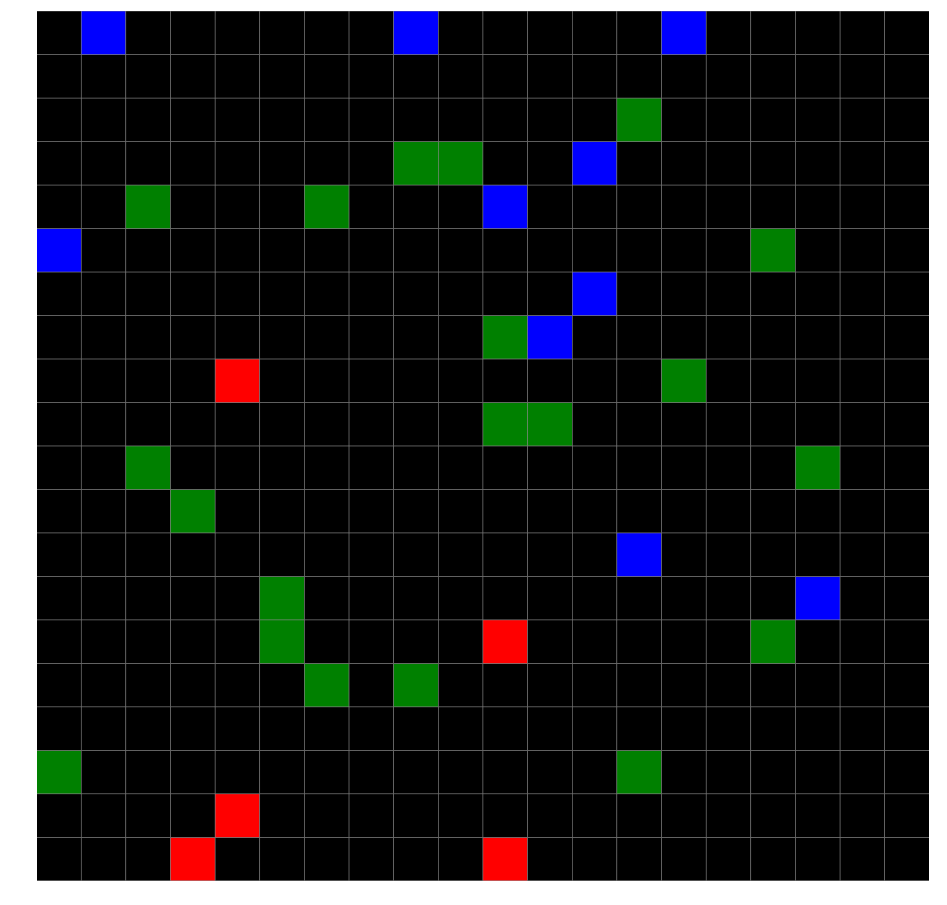

In [9]:
## Declarations
rows=20
data = np.zeros((rows, rows), dtype=int)

#Population of Species
numFoxes=6
numRabbits=20
numMushrooms=10

rabbit_step_size=8
fox_step_size=4
    
foxes_array=[]
rabbits_array=[]
mush_array=[]

## Initialise and Spawn Foxes & Rabbits
    
# Foxes
for i in range(numFoxes):
    fox = Fox(mapSize=rows, stepSize=fox_step_size)
    foxes_array.append(fox)
    
# Rabbits
for i in range(numRabbits):
    rabbit = Rabbit(mapSize=rows, stepSize=rabbit_step_size)
    rabbits_array.append(rabbit)
    
# Deploy Magic Mushrooms
for i in range(numMushrooms):
    mush = Mushroom(mapSize=rows)
    mush_array.append(mush)

# Graph
data = mapToGrid(data, foxes_array, rabbits_array, mush_array)
    
print('Initial condition')
#Empty = 0 (Black)
#Mushrooms = 1 (Blue)
#Rabbits = 2 (Green)
#Foxes = 3 (Red)
cmap = colors.ListedColormap(['Black','Blue','Green','Red'])
plt.figure(figsize=(16,16))
plt.pcolor(data[::-1],cmap=cmap,edgecolors='Grey', linewidths=0.5)
plt.axis('off')
plt.show()